# Chapter 9: Application of Image Processing in Medical Domain

## Problems

1. Loading and displaying medical images of different formats and modalities with `pydicom`, `nifti`, `itk`      
2. 3D visualization of Head **MRI** images with `matplotlib`, `vtk`, `vedo` and `visvis`   
3. Applying Filters with `medpy` and `itk`      
4. **Morphological** Filtering with `itk`      
5. **Computation Tomography** (**CT**) Reconstruction with **Inverse Radon Transform** with `scikit-image`      
6. Segementation of Brain MRI images with **Graphcut** algorithms with `medpy`      
7. **Pneumonia Classification** from Chest X-Ray with `XceptionNet`      

# Medical Image Processing

## Problem 1: Loading and displaying medical images of different formats and modalities with `pydicom`, `nifti`, `itk` libraries

In [ ]:
#! pip install pydicom
from glob import glob 
import pydicom 

ct_scan = [pydicom.read_file(dfile) for dfile in sorted(glob('images/MR*.dcm'))]
ct_scan_ordered = sorted(ct_scan, key=lambda slice: slice.SliceLocation) 

In [ ]:
plt.figure(figsize=(12,4))
plt.gray()
plt.subplots_adjust(0,0,1,0.95,0.01,0.01)
i = 1
for dicom_file in ct_scan_ordered:
  plt.subplot(3,9,i), plt.imshow(dicom_file.pixel_array ), plt.axis('off')
  i += 1
plt.suptitle('Full head MRI scan DICOM files', size=15)
plt.show()

If you run the above code snippet, you will get a figure like the following one which visualizes the dicom files corresponding to a full head MRI scan.

![](images/Img_06_11.png)

In [67]:
#!pip install nilabel
import nibabel as nib
nifti = nib.load('images/201_t2w_tse.nii.gz')
#print(nifti)
print(nifti.shape) # get the image shape
print(nifti.header.get_data_shape()) # get the image shape in a different way
image_array = nifti.get_fdata()
print(image_array.dtype, image_array.shape)

(256, 256, 27)
(256, 256, 27)
float64 (256, 256, 27)


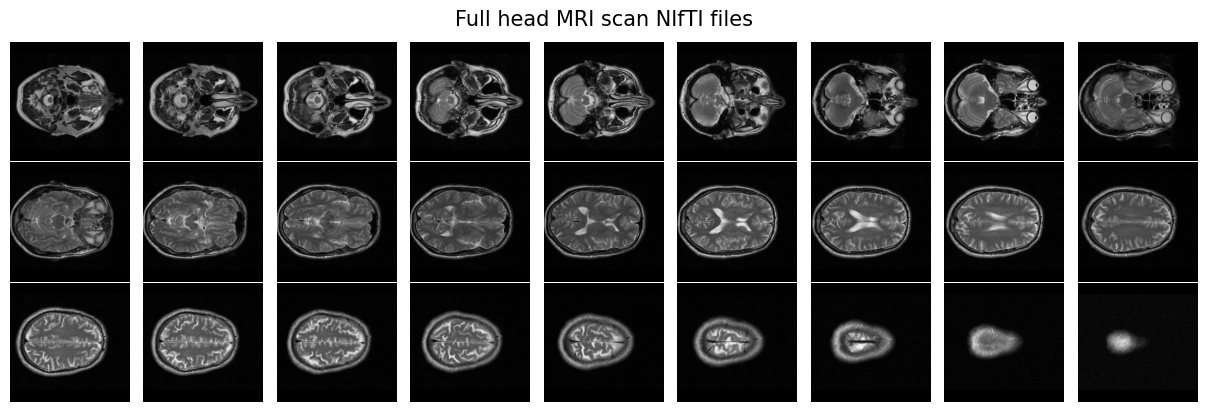

In [72]:
fig, axis = plt.subplots(3, 9, figsize=(12, 4))
plt.subplots_adjust(0,0,1,0.9,0.01,0.01)
slice_counter = 0
for i in range(3):
    for j in range(9):
        if slice_counter < image_array.shape[-1]:
          axis[i][j].imshow(image_array[:,:,slice_counter], cmap="gray")
        slice_counter+=1
        axis[i][j].axis('off')
plt.suptitle('Full head MRI scan NIfTI files', size=15)
plt.show()

In [62]:
#!pip install SimpleITK
import SimpleITK as sitk
import numpy as np
import matplotlib.pylab as plt

def load_itk(filename):
    itkimage = sitk.ReadImage(filename)
    ct_scan = sitk.GetArrayFromImage(itkimage)
    origin = np.array(list(reversed(itkimage.GetOrigin())))
    spacing = np.array(list(reversed(itkimage.GetSpacing())))
    return ct_scan, origin, spacing

ct, _, _ = load_itk('images/chest_ct.mhd')    
print(ct.shape)

(112, 256, 256)


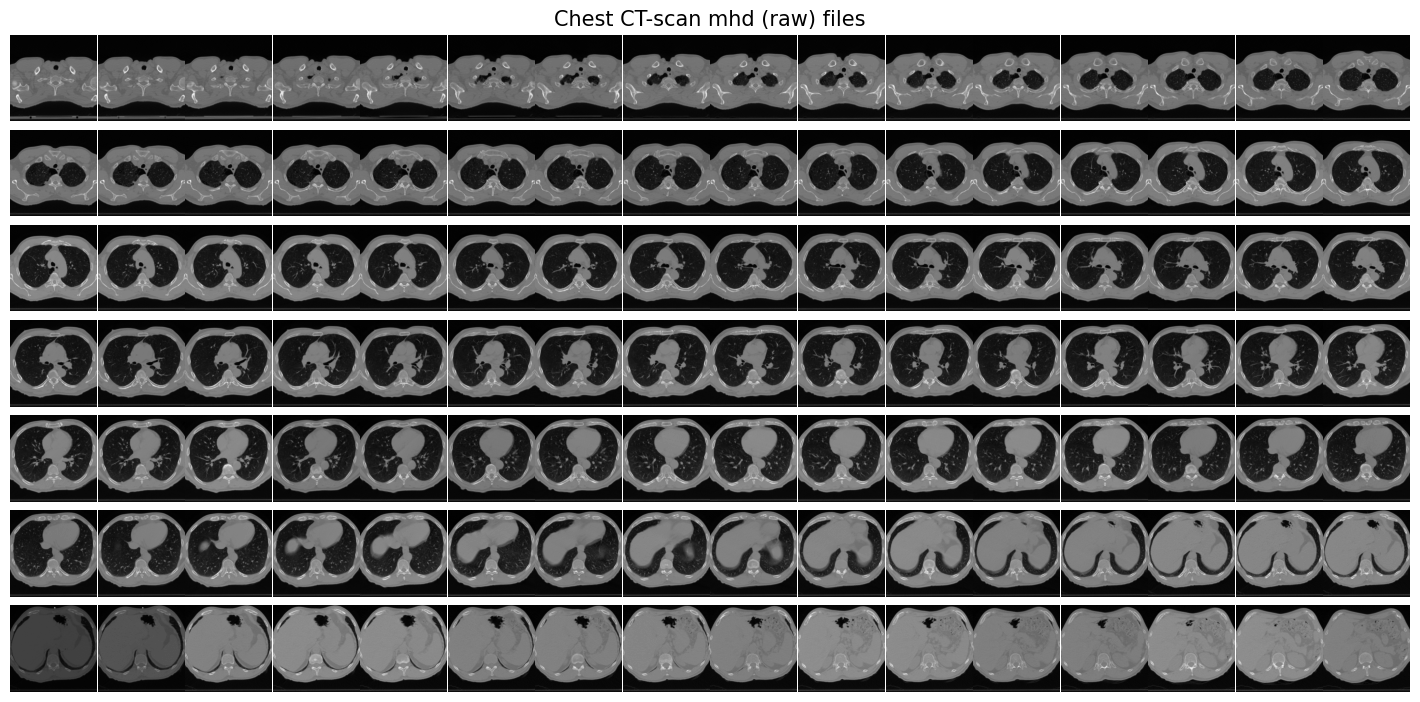

In [63]:
plt.figure(figsize=(14,7))
plt.gray()
plt.subplots_adjust(0,0,1,0.95,0.01,0.01)
for i in range(ct.shape[0]):
    plt.subplot(7,16,i+1), plt.imshow(ct[i]), plt.axis('off')
plt.suptitle('Chest CT-scan mhd (raw) files', size=15)
plt.show()

## Problem 2: 3D visualization of a Head MRI image with `matplotlib`, `vtk`, `vedo` and `visvis` 

In [ ]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
from skimage import measure
import pydicom
import matplotlib.pylab as plt
import SimpleITK as sitk

def load_itk(filename):
    itkimage = sitk.ReadImage(filename)
    ct_scan = sitk.GetArrayFromImage(itkimage)
    origin = np.array(list(reversed(itkimage.GetOrigin())))
    spacing = np.array(list(reversed(itkimage.GetSpacing())))
    return ct_scan, origin, spacing

def plot_3d(image, threshold=-300): 
    #p = image.transpose(2,1,0)
    #p = p[:,:,::-1]
    verts, faces, normals, values = measure.marching_cubes(p, threshold) #_lewiner
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)
    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])
    ax.set_title(f'3D plot with Marching Cubes algorithm (level={threshold})', size=15)
    plt.savefig('out_3d_{:03d}.png'.format(threshold))
    plt.close()

ct, _, _ = load_itk('iamges/FullHead.mhd')    
#ct = ct / ct.max()
print(ct.shape, ct.min(), ct.max())
plot_3d(ct, 1150)

If you run the above code, you should obtain a 3D visualization as shown in the next figure:

![](images/Img_06_12.png)

### with the library `visvis`

In [ ]:
import visvis as vv
ct, _, _ = load_itk('FullHead.mhd')    
verts, faces, normals, values = measure.marching_cubes_lewiner(ct, 1150) #1150
#vv.mesh(np.fliplr(verts), faces, normals, values)
vv.mesh(verts, faces, normals, values)
vv.use().Run()

If you run the above code, it should pop up a window with a 3D visualization as shown in the next figure:

![](images/Img_06_13.png)

### with the library `vedo`

In [ ]:
from vedo import *
verts, faces, _, _ = measure.marching_cubes(ct, 1150) 
Mesh([verts, faces]).c('jet').alpha(1.0).show()

If you run the above code, it should pop up a window with a 3D visualization as shown in the next figure:

![](images/Img_06_14.png)

## 3. Applying Filters with `medpy` and `itk`

In [ ]:
import scipy
from scipy.ndimage.filters import generic_gradient_magnitude, prewitt, sobel
from medpy.io import load, save
from medpy.core import Logger

**Gradient Filters with `medpy` and `scipy`**

In [ ]:
data_input, header_input = load('images/b0.nii.gz')
    
logger = Logger.getInstance()
        
# prepare result image
data_output = scipy.zeros(data_input.shape, dtype=scipy.float32)
    
# apply the gradient magnitude filter
generic_gradient_magnitude(data_input, prewitt, output=data_output) # alternative to prewitt is sobel

plt.figure(figsize=(20,7))
plt.bone()
plt.subplot(131), plt.imshow(data_input), plt.axis('off'), plt.title('original', size=20)
plt.subplot(132), plt.imshow(data_output), plt.axis('off'), plt.title('otuput gradient prewitt', size=20)
generic_gradient_magnitude(data_input, sobel, output=data_output) # alternative to prewitt is sobel
plt.subplot(133), plt.imshow(data_output), plt.axis('off'), plt.title('otuput gradient sobel', size=20)
plt.tight_layout()
plt.show()

If you run the above code snippet, you will obtain a figure like the following one:

![](images/Img_06_03.png)

**Sigmoid Filters with ITK**

In [ ]:
PixelType = itk.UC
Dimension = 2

ImageType = itk.Image[PixelType, Dimension]

reader = itk.ImageFileReader[ImageType].New()
reader.SetFileName('images/BrainProtonDensitySlice6.png')
input = reader.GetOutput()

sigmoidFilter = itk.SigmoidImageFilter[ImageType, ImageType].New()
sigmoidFilter.SetInput(input)
sigmoidFilter.SetOutputMinimum(0)
sigmoidFilter.SetOutputMaximum(1)

beta = 128
plt.figure(figsize=(20,7))
plt.subplots_adjust(0,0,1,0.9,0.05,0.05)
plt.subplot(1,3,1), plt.imshow(itk.GetArrayFromImage(input)), plt.axis('off'), plt.title('input', size=15)
i = 2
for alpha in [1.2, 1.5]:
    sigmoidFilter.SetAlpha(alpha)
    sigmoidFilter.SetBeta(beta)
    output = sigmoidFilter.GetOutput()
    plt.subplot(1,3,i), plt.imshow(itk.GetArrayFromImage(output)), plt.axis('off')
    plt.title(r'$\alpha$={}'.format(alpha), size=15)
    i += 1
plt.suptitle('Applying Sigmoid Filter on an Image with itk', size=20)
plt.show()

If you run the above code snippet, you will obtain a figure like the following one (`sigmoid` filter with different values of $\alpha$):

![](images/Img_06_05.png)

**Overlay Filters with ITK and OpenCV**

In [6]:
import nibabel as nib
import itk
import cv2
import numpy as np

prostate_images = nib.load('images/prostate_00.nii.gz').get_fdata()
prostate_images = (255*prostate_images / prostate_images.max()).astype(np.uint8)
prostate_labels = nib.load('images/label_prostate_00.nii.gz').get_fdata().astype(np.uint8)
print(prostate_images.shape, prostate_labels.shape)

(320, 320, 15, 2) (320, 320, 15)


In [ ]:
LabelType = itk.ctype("unsigned long")
LabelObjectType = itk.StatisticsLabelObject[LabelType, Dimension]
LabelMapType = itk.LabelMap[LabelObjectType]

i = 8
converter = itk.LabelImageToLabelMapFilter[ImageType, LabelMapType].New()
converter.SetInput(itk.GetImageFromArray(prostate_labels[...,i]))

RGBImageType = itk.Image[itk.RGBPixel[PixelType], Dimension]
overlayFilter = itk.LabelMapOverlayImageFilter[LabelMapType, ImageType, RGBImageType].New()
overlayFilter.SetInput(converter.GetOutput())
overlayFilter.SetFeatureImage(itk.GetImageFromArray(prostate_images[...,i,0]))
overlayFilter.SetOpacity(0.5)

plt.figure(figsize=(20,7))
plt.gray()
plt.subplot(131), plt.imshow(prostate_images[...,i,0]), plt.axis('off'), plt.title('input (prostate CT)', size=20)
plt.subplot(132), plt.imshow(prostate_labels[...,i]), plt.axis('off'), plt.title('label', size=20)
plt.subplot(133), plt.imshow(cv2.rotate(itk.GetArrayFromImage(overlayFilter.GetOutput()), cv2.ROTATE_90_COUNTERCLOCKWISE)), plt.axis('off'), plt.title('overlayed label (with itk)', size=20)
plt.tight_layout()
plt.show()

#itk.imwrite(overlayFilter.GetOutput(), 'output.png')

If you run the above code snippet, you will obtain a figure like the following one:

![](images/Img_06_07.png)

### Problem 4: Morphological Filtering with the library `ITK`

In [1]:
#! pip install itk
import itk
import matplotlib.pylab as plt
import sys

In [ ]:
itk.auto_progress(2)

input_image = "images/cthead15.png"
output_image = "images/output.png"
radius = 5
PixelType = itk.UC
Dimension = 2

ImageType = itk.Image[PixelType, Dimension]
ReaderType = itk.ImageFileReader[ImageType]
reader = ReaderType.New()
reader.SetFileName(input_image)

StructuringElementType = itk.FlatStructuringElement[Dimension]
structuringElement = StructuringElementType.Ball(radius)
input = reader.GetOutput()
GrayscaleFilterType = itk.GrayscaleErodeImageFilter[ImageType, ImageType, StructuringElementType]
grayscaleFilter = GrayscaleFilterType.New()
grayscaleFilter.SetInput(input)
grayscaleFilter.SetKernel(structuringElement)
output_erosion = grayscaleFilter.GetOutput()

GrayscaleFilterType = itk.GrayscaleDilateImageFilter[ImageType, ImageType, StructuringElementType].New()
grayscaleFilter = GrayscaleFilterType.New()
grayscaleFilter.SetInput(input)
grayscaleFilter.SetKernel(structuringElement)
output_dilation = grayscaleFilter.GetOutput()

WriterType = itk.ImageFileWriter[ImageType]
writer = WriterType.New()
writer.SetFileName(output_image)
writer.SetInput(output_erosion)
writer.Update()

If you run the above code snippet and display the input image along with the output images obtained using morphological erosion and dilation operations side-by-side, you should obtain a figure like the following one:

![](images/Img_06_04.png)

### Hole Filling

In [ ]:
import itk
import matplotlib.pylab as plt

PixelType = itk.UC
Dimension = 2

ImageType = itk.Image[PixelType, Dimension]

reader = itk.ImageFileReader[ImageType].New()
reader.SetFileName('images/BinaryThresholdImageFilter.png')
input = reader.GetOutput()

radius = 5

binaryFilter = itk.VotingBinaryIterativeHoleFillingImageFilter[ImageType].New()
binaryFilter.SetInput(input)

plt.figure(figsize=(15,5))
plt.gray()
plt.subplots_adjust(0,0,1,0.9,0.05,0.05)
plt.subplot(1,3,1), plt.imshow(int(itk.GetArrayFromImage(input))), plt.axis('off'), plt.title('input', size=15)
i = 2
for radius in [3, 5]:
    binaryFilter.SetRadius(radius)
    binaryFilter.SetMajorityThreshold(10)
    binaryFilter.SetBackgroundValue(0);
    binaryFilter.SetForegroundValue(255);
    binaryFilter.SetMaximumNumberOfIterations(20);
    output = binaryFilter.GetOutput()
    plt.subplot(1,3,i), plt.imshow(itk.GetArrayFromImage(output)), plt.axis('off')
    plt.title('radius={}'.format(radius), size=15)
    i += 1
plt.suptitle('Iterative Hole Filling with itk', size=20)
plt.show()

## Problem 5: Computation Tomography Reconstruction with Inverse Radon Transform using `scikit-image`

### Inverse Radon Transform

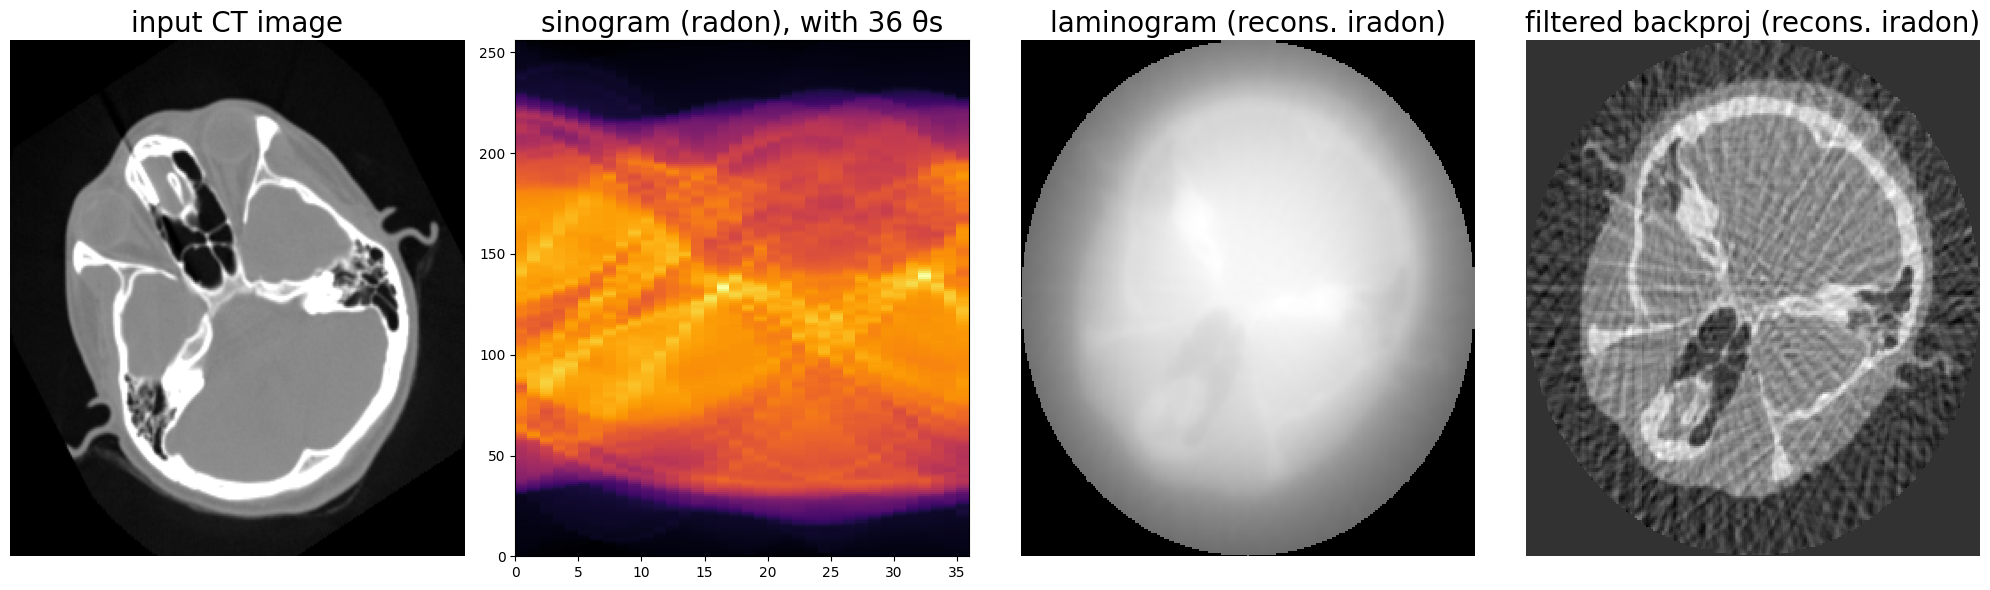

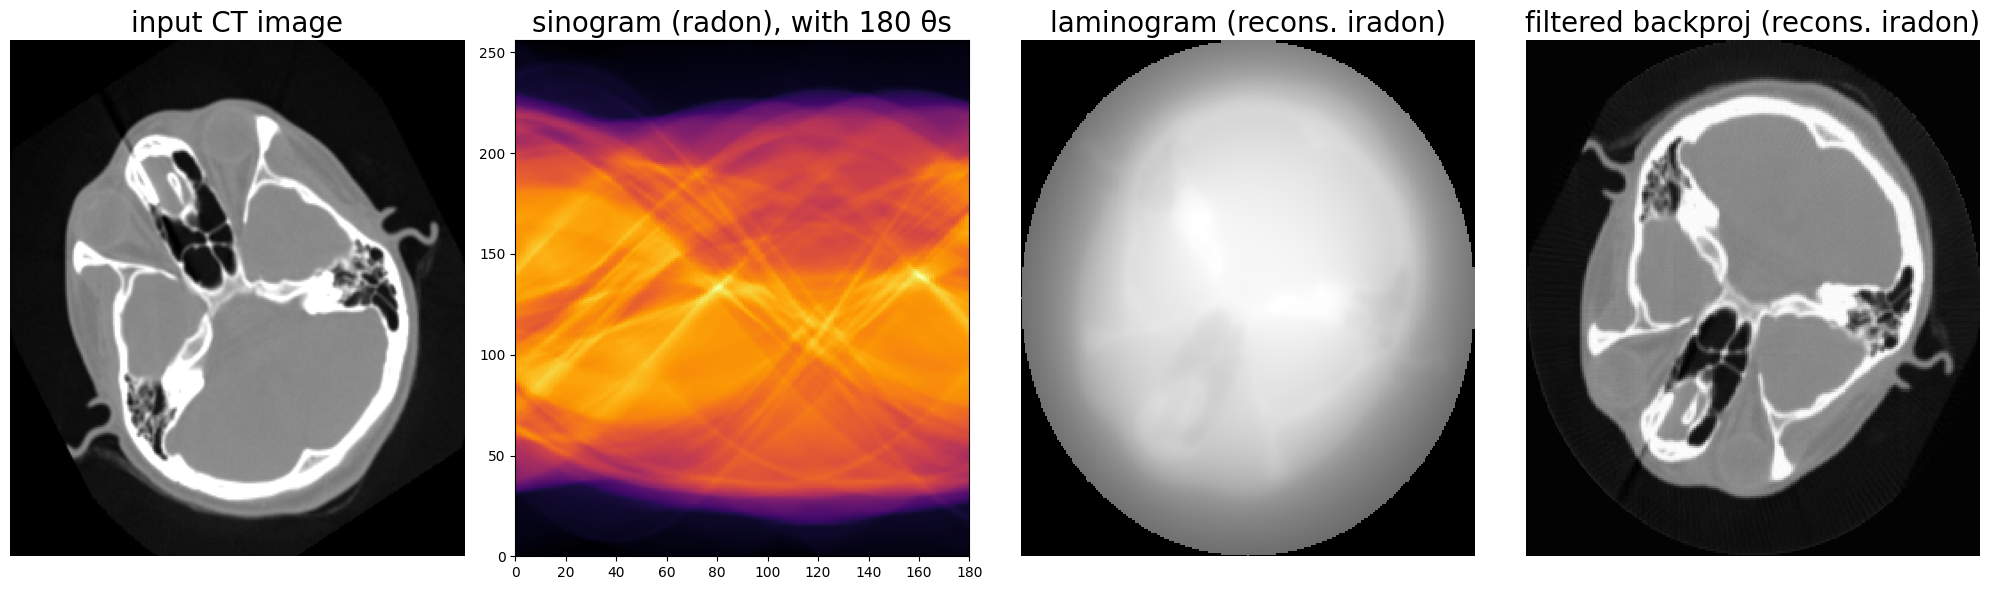

In [10]:
from skimage.transform import radon, iradon
from skimage.io import imread
import numpy as np
import matplotlib.pylab as plt
import warnings
warnings.filterwarnings('ignore')

im = imread('images/cthead15.png', 1)
for dθ in [5, 1]:
    θ = np.arange(0., 180., dθ)
    plt.figure(figsize=(20,6))
    plt.gray()
    plt.subplot(141), plt.imshow(im, aspect='auto'), plt.axis('off'), plt.title('input CT image', size=20)
    sinogram = radon(im, theta=θ)
    plt.subplot(142), plt.pcolor(sinogram, cmap='inferno'), plt.title(f'sinogram (radon), with {len(θ)} θs', size=20)
    recons_im = iradon(sinogram, theta=θ, filter_name=None)
    plt.subplot(143), plt.pcolor(recons_im), plt.axis('off'), plt.title('laminogram (recons. iradon)', size=20)
    recons_im = iradon(sinogram, theta=θ, filter_name='ramp')
    plt.subplot(144), plt.pcolor(recons_im), plt.axis('off'), plt.title('filtered backproj (recons. iradon)', size=20)
    plt.tight_layout()
    plt.show()

## Problem 6: Segementation of Brain MRI images with Graphcut algorithms with `medpy`

In [ ]:
from medpy import graphcut, filter
from medpy.graphcut.wrapper import split_marker
from medpy.core import ArgumentError, Logger
from medpy.io import load, save
import scipy
import numpy as np
import matplotlib.pylab as plt
import logging, os

In [ ]:
def graphcut_label():
    
    logger = Logger.getInstance()
    logger.setLevel(logging.INFO)    
    boundary_term = graphcut.energy_label.boundary_stawiaski
    logger.info('Selected boundary term: stawiaski')
    
    region_image_data, reference_header = load('b0.nii.gz')
    badditional_image_data, _ = load('b1000.nii.gz')
    markers_image_data, _ = load('b0markers.nii.gz')
    markers_image_data = np.squeeze(markers_image_data)
    region_image_data_orig = region_image_data.copy()
    
    fgmarkers_image_data, bgmarkers_image_data = split_marker(markers_image_data)
       
    # check if all images dimensions are the same
    if not (badditional_image_data.shape == region_image_data.shape == fgmarkers_image_data.shape == bgmarkers_image_data.shape):
        logger.critical('Not all of the supplied images are of the same shape.')
        raise ArgumentError('Not all of the supplied images are of the same shape.')
       
    # recompute the label ids to start from id = 1
    region_image_data = filter.relabel(region_image_data)

    gcgraph = graphcut.graph_from_labels(region_image_data,
                                    fgmarkers_image_data,
                                    bgmarkers_image_data,
                                    boundary_term = boundary_term,
                                    boundary_term_args = (badditional_image_data)) # second is directedness of graph , 0)

    del fgmarkers_image_data
    del bgmarkers_image_data
    
    maxflow = gcgraph.maxflow()    
    # apply results to the region image
    mapping = [0] # no regions with id 1 exists in mapping, entry used as padding
    mapping.extend([0 if gcgraph.termtype.SINK == gcgraph.what_segment(int(x) - 1) else 1 for x in scipy.unique(region_image_data)])
    region_image_data = filter.relabel_map(region_image_data, mapping)

    plt.figure(figsize=(20,7))
    plt.gray()
    plt.subplot(141), plt.imshow(region_image_data_orig), plt.axis('off'), plt.title('input', size=20)
    plt.subplot(142), plt.imshow(badditional_image_data), plt.axis('off'), plt.title('additional', size=20)
    plt.subplot(143), plt.imshow(markers_image_data), plt.axis('off'), plt.title('marker', size=20)
    plt.subplot(144), plt.imshow(region_image_data), plt.axis('off'), plt.title('output graphcut segmentation', size=20)
    plt.tight_layout()
    plt.show()
    
graphcut_label()

If you run the above code, you should obtain a figure like the following one:

![](images/Img_06_01.png)

### Graph Cut Voxel Segmentation

In [ ]:
def graphcut_voxel():
    logger = Logger.getInstance()
    logger.setLevel(logging.INFO)            
    boundary_term = graphcut.energy_voxel.boundary_difference_power
    logger.info('Selected boundary term: power based / raised difference of intensities')

    badditional_image_data, reference_header = load('images/b1000.nii.gz')
    markers_image_data, _ = load('images/b0markers.nii.gz')
    markers_image_data = np.squeeze(markers_image_data)
    
    fgmarkers_image_data, bgmarkers_image_data = split_marker(markers_image_data)
       
    # check if all images dimensions are the same
    if not (badditional_image_data.shape == fgmarkers_image_data.shape == bgmarkers_image_data.shape):
        logger.critical('Not all of the supplied images are of the same shape.')
        raise ArgumentError('Not all of the supplied images are of the same shape.')

    # extract spacing if required
    spacing = header.get_pixel_spacing(reference_header)
    logger.info('Taking spacing of {} into account.'.format(spacing))
    #spacing = False

    sigma = 10
    logger.info('Preparing BK_MFMC C++ graph...')
    gcgraph = graphcut.graph_from_voxels(fgmarkers_image_data,
                                         bgmarkers_image_data,
                                         boundary_term = boundary_term,
                                         boundary_term_args = (badditional_image_data, sigma, spacing))    
    logger.info('Executing min-cut...')
    maxflow = gcgraph.maxflow()
    logger.debug('Maxflow is {}'.format(maxflow))
    
    # reshape results to form a valid mask
    logger.info('Applying results...')
    result_image_data = scipy.zeros(bgmarkers_image_data.size, dtype=scipy.bool_)
    for idx in range(len(result_image_data)):
        result_image_data[idx] = 0 if gcgraph.termtype.SINK == gcgraph.what_segment(idx) else 1    
    result_image_data = result_image_data.reshape(bgmarkers_image_data.shape)
    
    # save resulting mask    
    result_image_data1 = np.zeros((result_image_data.shape[0], result_image_data.shape[1], 3))
    result_image_data1[..., 0] = result_image_data1[..., 2] = 255*result_image_data
    output = (0.4*result_image_data1+0.6*gray2rgb(badditional_image_data)).astype(np.uint8)

    plt.figure(figsize=(20,7))
    plt.gray()
    plt.subplot(131), plt.imshow(badditional_image_data), plt.axis('off'), plt.title('input', size=20)
    plt.subplot(132), plt.imshow(markers_image_data), plt.axis('off'), plt.title('marker', size=20)
    plt.subplot(133), plt.imshow(output), plt.axis('off'), plt.title('output graphcut voxel segmentation', size=20)
    plt.tight_layout()
    plt.show()

graphcut_voxel()

If you run the above code snippet, you should obtain a figure like the following one:

![](images/Img_06_02.png)

Graph Cut segmentation is a powerful tool for segmenting complex medical images like brain MRI. By formulating the problem as a graph, it leverages global optimization techniques to produce highly accurate segmentation results. The medpy library provides an efficient implementation of graph cut segmentation for both 2D and 3D medical images, making it a valuable tool for medical image analysis.

## Problem 7: Pneumonia Classification from Chest X-Ray using `XceptionNet` with `tensorflow`

  ![](images/kaggle.png)

In [ ]:
# import function to upload files (upload kaggle.json)
from google.colab import files
# Upload Kaggle key
files.upload()

- If you run the above command from inside the notebook in colab, an oepn-filedialog control should open from which you can choose the json file from the right path from your local machine, as shown below.

![](images/colab.png)

- Install the **Kaggle API** in the **Colab** environment (using the following line of code, with `pip`), which allows you to download datasets from Kaggle directly. The `-q` flag runs the installation in quiet mode, meaning it doesn't show detailed installation logs.

In [ ]:
!pip install -q kaggle

In [ ]:
#! mkdir ~/.kaggle
#! cp kaggle.json ~/.kaggle/
#! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# !kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
# !unzip chest-xray-pneumonia.zip

In [ ]:
%tensorflow_version 2.x

- Let's import the required `python` libraries, modules and functions, using the next code snippet.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import img_to_array, array_to_img
from keras import backend as K
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from PIL import Image
import cv2
import numpy as np

from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pathlib, gc

In [ ]:
RESCALE     = 1./255
BATCH_SIZE  = 64
IMG_HEIGHT, IMG_WIDTH = 150, 150
IMG_SHAPE   = (IMG_HEIGHT, IMG_WIDTH, 3)
TARGET_SIZE = (IMG_HEIGHT, IMG_WIDTH)
SHUFFLE_BUFFER_SIZE = 6000

In [ ]:
def reset_graph(model=None):
    if model:
        try:
            del model
        except:
            return False
    K.clear_session()
    gc.collect()
    return True

reset_graph()

In [ ]:
root_dir = "./"
dataset_root_dir = r"chest_xray/"
# input dir
train_dir   = pathlib.Path(dataset_root_dir + r"train")
test_dir    = pathlib.Path(dataset_root_dir + r"test")
val_dir     = pathlib.Path(dataset_root_dir + r"val")
# output dir
output_dir          = root_dir + r"data/output/"
output_figures_dir  = output_dir + "figures"

temp = root_dir
for d in output_figures_dir.split('/'):
    temp += d + "/"
    if not os.path.exists(temp):
        os.mkdir(temp)

train_data_count    = len(list(train_dir.glob('*/*.jpeg')))
test_data_count     = len(list(test_dir.glob('*/*.jpeg')))
val_data_count      = len(list(val_dir.glob('*/*.jpeg')))

TOTAL_IMAGE_COUNT   = train_data_count + test_data_count + val_data_count
STEPS_PER_EPOCH = np.ceil(TOTAL_IMAGE_COUNT/BATCH_SIZE)

In [ ]:
def preprocess_image(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img /= 255.0  # Normalize to [0, 1] range
    return img

def get_label(file_path):
    parts = tf.strings.split(file_path, '/')
    return parts[-2] == CLASS_NAMES

def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

def load_image_train(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

def load_image_test(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [ ]:
train_dir_ = str(train_dir/'*/*')
val_dir_ = str(val_dir/'*/*')
test_dir_ = str(test_dir/'*/*')

train_dataset = tf.data.Dataset.list_files(train_dir_)
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE)
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.list_files(val_dir_)
val_dataset = val_dataset.shuffle(SHUFFLE_BUFFER_SIZE)
val_dataset = val_dataset.map(load_image_test)
val_dataset = val_dataset.batch(val_data_count)

test_dataset = tf.data.Dataset.list_files(test_dir_)
test_dataset = test_dataset.shuffle(SHUFFLE_BUFFER_SIZE)
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(test_data_count)
train_dataset, val_dataset, test_dataset

In [ ]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = keras.applications.xception.Xception(
    input_tensor = inputs, # pass input to input_tensor 
    include_top = False,
    weights = 'imagenet'
)
x.trainable = False

# flat the base model with x.output 
x = tf.keras.layers.BatchNormalization()(x.output) 
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(2, activation='softmax')(x)

model = tf.keras.Model(inputs, x)

In [ ]:
INITIAL_LEARNING_RATE = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=INITIAL_LEARNING_RATE)
loss = 'categorical_crossentropy'
metrics = ['accuracy']

model.compile(
    loss=loss,     
    optimizer=optimizer, 
    metrics=metrics
)

y_labels = np.argmax(next(iter(train_dataset))[1].numpy(), axis=1)
classweights = class_weight.compute_class_weight(class_weight = "balanced", classes = np.unique(y_labels), y = y_labels)
classweights = dict(zip(np.unique(y_labels), classweights))

INITIAL_EPOCH = 10
history = model.fit(
        train_dataset,
        class_weight = classweights,
        shuffle = True,
        validation_data = val_dataset,
        epochs = INITIAL_EPOCH,
        verbose = 1
    )

plot_learning_curves(history)

If you run the above code to train the model, you should get a figure like the following one:

![](images/Img_06_21.png)

In [ ]:
x_test, y_test = next(iter(test_dataset))
score = model.evaluate(x_test.numpy(), y_test.numpy(), verbose=0)
print('Model Loss: {}, Accuracy: {}'.format(score[0], score[1]))

If you run the above code snippet, you should get an output like the following one:

![](images/Img_06_24.png)

In [ ]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict(x_test.numpy())
y_pred_classes = np.argmax(y_pred, axis = 1) 
y_true = np.argmax(y_test.numpy(), axis = 1) 

Now use the function `sklearn.metrics.confusion_matrix(y_true, y_pred)` or the function `sklearn.metrics.ConfusionMatrixDisplay(model, x_test, y_test)` to display the confusion matrix as shown in the next figure.

![](images/Img_06_23.png)

### GRAD-CAM

In [ ]:
def get_img_array(img_path, size):
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    return np.expand_dims(keras.preprocessing.image.img_to_array(img), axis=0)

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(id, alpha=0.4):
    img = x_test[id].numpy()
    img_array = np.expand_dims(img, axis=0)
    preds = model.predict(img_array)
    #print("Predicted:", preds, np.argmax(preds, axis=1)[0], 'Actual:', np.argmax(y_test[id].numpy()))
    last_conv_layer_name = "conv_7b_ac" #"block5_conv3" #"block14_sepconv2_act" #"block5_conv3" #"vgg16"
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    heatmap = np.uint8(255 * heatmap)
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((IMG_WIDTH, IMG_HEIGHT))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)
    superimposed_img = jet_heatmap * alpha + 255 * img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    superimposed_img.save(cam_path)
    display(Image(cam_path))

save_and_display_gradcam(10)

If you run the above code snippet, you should get a figure like the following one:

![](images/Img_06_22.png)

The following figure shows a few chest X-ray `test` images with **ground-truth** (**true**) vs. **predicted** labels, the code to produce the following visualization is left as an exercise, it should be pretty straightforward.

![](images/Img_06_25.png)

## Questions

1. Convert medical images in **DICOM** format to **NIfTI** format (hint: use the library `dicom2nifti`).

2. Brain Tumor Detection using **transfer learning** with **Mask R-CNN** with Medical Decathlon dataset: Download the dataset `Task01_BrainTumour.tar` from the **Gdrive** from  http://medicaldecathlon.com/. Refer to the problem 11 from the last chapter (chapter 5) (Custom Object Detection and Instance Segmentation with Mask R-CNN). Select (e.g., $2000$ images) randomly from the training dataset along with the labels and create annotation jsons from the labels (e.g., define a function to create annotations and bounding boxes), you should obtain annotated images as shown in the next figure.

![](images/Img_06_18.png)

Partition the annotated images into two sets: `training` and `validation`. Use the function `load_image_dataset()` to load the train and validation images along with annotations. There should be only $1$ class corresponding to `'Tumor'`, that we want to detect. If you use `display_image_samples()` on an image with annotation you should obtain a figure like the following one:

![](images/Img_06_19.png)

Train the model (e.g., for $10$ epochs) on the annotated images, by freezing all the layers except the head layers. After training is over, use the model for inference, to predict the tumor region (along with the bounding box) of a (held-out) `test` image and overlay on top the actual label (use the `color_spalsh()` function), You should obtain a figure like the following, for the given test image:

![](images/Img_06_20.png)

3. Implement a function to compute the **IOU** (**Intersection over Union (IoU)**) of the model on the test images, from the previous question, to evaluate the model. Remember that the IoU measures the overlap between the predicted bounding box and the ground truth bounding box. It is defined as the area of overlap divided by the area of union between the predicted and ground truth boxes.

## References

1. https://www.researchgate.net/publication/28359596_Interactive_Liver_Tumor_Segmentation_Using_Graph-cuts_and_Watershed
2. https://github.com/mateuszbuda/brain-segmentation-pytorch/tree/master
4. https://arxiv.org/pdf/1610.02391
8. http://medicaldecathlon.com/
9. https://ieeexplore.ieee.org/document/8099678
10. https://www.youtube.com/watch?v=_eYIh7fxucM
11. https://www.youtube.com/watch?v=EzTsOSJRGwE
5. https://www.youtube.com/watch?v=hcqnEkfs6u8
6. https://www.youtube.com/watch?v=eCaXIPKz7yc
11. https://www.youtube.com/watch?v=pFKARAl-wzA
17. https://www.youtube.com/watch?v=eW6LWmkigrc